# Diagnostic Tools Walkthrough

This notebook provides a comprehensive walkthrough of all diagnostic tools for analyzing VLM (Vision-Language Model) performance, specifically for LLaVA models.

## Overview

This notebook will guide you through:
1. **Setup and Installation** - Installing dependencies and setting up the environment
2. **Model Downloads** - Downloading pre-trained models from Hugging Face
3. **COCO Dataset Setup** - Downloading and preparing the COCO dataset
4. **Token Norms Analysis** - Analyzing L2-norm distributions for vision and text tokens
5. **COCO Diagnostics** - Running comprehensive diagnostics over COCO dataset
6. **RoPE Sensitivity Analysis** - Analyzing positional encoding sensitivity
7. **System Prompt Analysis** - Visualizing attention allocation to system prompts
8. **Cross Modality Balance (CMB)** - Analyzing vision vs text token attention shares
9. **Hidden Norms Visualization** - Comparing hidden norms across layers
10. **Attention Heatmaps** - Visualizing attention patterns over images

---


## 1. Setup and Installation

First, let's install all required dependencies. This includes PyTorch, transformers, and other necessary packages.

Install the following and wait for the notebook to auto-restart

In [1]:
# Check if we're in a Colab environment
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
except:
    IN_COLAB = False
    print("Running in local Jupyter environment")

# Install system dependencies (for Colab)
if IN_COLAB:
    import sys, subprocess, site, os, textwrap

    py = sys.executable

    def pip(*args):
        print(">", py, "-m", "pip", *args)
        subprocess.check_call([py, "-m", "pip", *args])

    # 1) Remove any existing installs that could shadow the target version
    pip("uninstall", "-y", "transformers")
    # 2) Install the exact versions with NO deps (prevents auto-upgrade back to 4.57)
    pip("install", "--no-deps", "transformers==4.37.2")
    pip("install", "-U", "tokenizers==0.15.2", "accelerate==0.25.0", "sentencepiece==0.1.99")

    # 3) Show where it installed
    subprocess.check_call([py, "-m", "pip", "show", "transformers"])
    !pip install seaborn
    !pip install numpy==1.26.4 opencv-python
    !pip install -q condacolab
    import condacolab
    condacolab.install()


Running in Google Colab
> /usr/bin/python3 -m pip uninstall -y transformers
> /usr/bin/python3 -m pip install --no-deps transformers==4.37.2
> /usr/bin/python3 -m pip install -U tokenizers==0.15.2 accelerate==0.25.0 sentencepiece==0.1.99
⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:06
🔁 Restarting kernel...


Ensure the installation are okay.
If it is not okay or the version is false then re-install the cell above

In [1]:
import condacolab
condacolab.check()
import transformers, torch
print("Correct transformers version:", transformers.__version__ =='4.37.2')

✨🍰✨ Everything looks OK!
Correct transformers version: True


In [ ]:
!git clone https://github.com/user074/beyond-semantics.git

In [ ]:
%cd /content/beyond-semantics
!pip install -e ./LLaVA --quiet

In [4]:
!conda env update -n base -f environment.yaml
print("✓ Core dependencies installed")



Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: | failed

SpecsConfigurationConflictError: Requested specs conflict with configured specs.
  requested specs: 
    - _libgcc_mutex==0.1=conda_forge
    - _openmp_mutex==4.5=2_gnu
    - asttokens==2.4.1=pyhd8ed1ab_0
    - bzip2==1.0.8=h5eee18b_6
    - ca-certificates==2024.9.24=h06a4308_0
    - comm==0.2.2=pyhd8ed1ab_0
    - debugpy==1.8.6=py310hf71b8c6_0
    - decorator==5.1.1=pyhd8ed1ab_0
    - exceptiongroup==1.2.2=pyhd8ed1ab_0
    - executing==2.1.0=pyhd8ed1ab_0
    - importlib-metadata==8.5.0=pyha770c72_0
    - ipykernel==6.29.5=pyh3099207_0
    - ipython==8.28.0=pyh707e725_0
    - jedi==0.19.1=pyhd8ed1ab_0
    - jupyter_client==8.6.3=pyhd8ed1ab_0
    - jupyter_core==5.7.2=pyh31011fe_1
    - krb5==1.21.3=h143b758_0
    - ld_impl_linux-64==2.40=h12ee557_0
    - libedit==3.1.20230828=h5eee18b_0
    - libffi==3.4.4=h6a678d5_1
    - libgcc==14.1.0=h77fa898_1
    - libgcc-ng==14.1.0=h69a702a_1
    - libgomp==

In [5]:
# Clone the repository if not already present
import os
import sys

if not os.path.exists('LLaVA'):
    print("Cloning LLaVA repository...")
    !git clone https://github.com/haotian-liu/LLaVA.git
    print("✓ LLaVA repository cloned")
else:
    print("✓ LLaVA repository already exists")

if not os.path.exists('VLM-Visualizer'):
    print("Cloning VLM-Visualizer repository...")
    !git clone https://github.com/zjysteven/VLM-Visualizer.git
    print("✓ VLM-Visualizer repository cloned")
else:
    print("✓ VLM-Visualizer repository already exists")

# Add to path
if 'LLaVA' not in sys.path:
    sys.path.append('LLaVA')
    sys.path.append('.')

print("✓ Paths configured")


✓ LLaVA repository already exists
Cloning VLM-Visualizer repository...
Cloning into 'VLM-Visualizer'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 123 (delta 31), reused 110 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (123/123), 3.08 MiB | 8.42 MiB/s, done.
Resolving deltas: 100% (31/31), done.
✓ VLM-Visualizer repository cloned
✓ Paths configured


In [6]:
# Verify installation
import torch
import transformers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print("\n✓ All packages imported successfully")


PyTorch version: 2.8.0+cu126
Transformers version: 4.37.2
CUDA available: True
CUDA device: NVIDIA L4
CUDA memory: 23.80 GB

✓ All packages imported successfully


## 2. Configuration

Set up paths and configuration for models and data. **Update the Hugging Face model paths below** when you have them.


In [ ]:
# Configuration
import os
from pathlib import Path
%cd /content/beyond-semantics
# Base directories
BASE_DIR = Path.cwd()
CHECKPOINTS_DIR = BASE_DIR / "checkpoints"
DATA_DIR = BASE_DIR / "Data"
OUTPUTS_DIR = BASE_DIR / "outputs"
RUNS_DIR = BASE_DIR / "runs"

# Create directories
CHECKPOINTS_DIR.mkdir(exist_ok=True)
DATA_DIR.mkdir(exist_ok=True)
OUTPUTS_DIR.mkdir(exist_ok=True)
RUNS_DIR.mkdir(exist_ok=True)

# Model paths (UPDATE THESE WITH YOUR HUGGING FACE LINKS)
MODELS = {
    "llava-v1.5-7b": "liuhaotian/llava-v1.5-7b",  # TODO: Replace with your HF link
    "llava-v1.5-7b-normWmean": "user074/llava-v1.5-7b-normWmean",  # TODO: Replace
    "llava-v1.5-7b-multilayerNorm": "user074/llava-v1.5-7b-multilayerNorm",  # TODO: Replace
    "clip-vit-large-patch14-336": "openai/clip-vit-large-patch14-336",
    # "vicuna-7b-v1.5": "lmsys/vicuna-7b-v1.5"
}

# COCO dataset paths
COCO_ROOT = DATA_DIR / "COCO"
COCO_IMAGE_DIR = COCO_ROOT / "val2017"
COCO_ANN_FILE = COCO_ROOT / "annotations" / "captions_val2017.json"

# Device configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
print(f"\nConfiguration:")
print(f"  Base directory: {BASE_DIR}")
print(f"  Checkpoints: {CHECKPOINTS_DIR}")
print(f"  Data: {DATA_DIR}")
print(f"  Outputs: {OUTPUTS_DIR}")
print(f"  Runs: {RUNS_DIR}")

import os, sys
project_root = "/content/beyond-semantics"
os.environ["PYTHONPATH"] = f"{project_root}:{project_root}/LLaVA:" + os.environ.get("PYTHONPATH", "")
print("PYTHONPATH=", os.environ["PYTHONPATH"])

## 3. Download Models from Hugging Face

Download the pre-trained models. The models will be cached by Hugging Face, so subsequent runs will be faster.


In [ ]:
from huggingface_hub import snapshot_download
from tqdm import tqdm
import os

def download_model(model_name, hf_path, local_dir=None, max_workers=8):
    """Download a model from Hugging Face with faster parallel downloads"""
    if local_dir is None:
        local_dir = CHECKPOINTS_DIR / model_name

    if os.path.exists(local_dir) and len(os.listdir(local_dir)) > 0:
        print(f"✓ {model_name} already exists at {local_dir}")
        return local_dir

    print(f"Downloading {model_name} from {hf_path}...")
    try:
        snapshot_download(
            repo_id=hf_path,
            local_dir=str(local_dir),
            local_dir_use_symlinks=False,
            resume_download=True,
            max_workers=max_workers  # Enable parallel downloads (default is 8)
        )
        print(f"✓ {model_name} downloaded successfully")
        return local_dir
    except Exception as e:
        print(f"✗ Error downloading {model_name}: {e}")
        return None

# Download models
print("Downloading models from Hugging Face...\n")
model_paths = {}
for model_name, hf_path in MODELS.items():
    if hf_path.startswith("YOUR_HF"):
        print(f"⚠ Skipping {model_name} - please update the Hugging Face path")
        continue
    path = download_model(model_name, hf_path, max_workers=8)  # Adjust max_workers as needed
    if path:
        model_paths[model_name] = path

print("\n✓ Model download complete")

## 4. Download COCO Dataset

Download the COCO validation set (2017) for diagnostics. This includes images and annotations.


In [ ]:
import urllib.request
import zipfile
import json

def download_file(url, dest_path, desc="File"):
    """Download a file with progress bar"""
    if os.path.exists(dest_path):
        print(f"✓ {desc} already exists: {dest_path}")
        return True

    print(f"Downloading {desc}...")
    try:
        def show_progress(block_num, block_size, total_size):
            downloaded = block_num * block_size
            percent = min(downloaded * 100 / total_size, 100)
            print(f"\r  Progress: {percent:.1f}%", end="", flush=True)

        urllib.request.urlretrieve(url, dest_path, show_progress)
        print(f"\n✓ {desc} downloaded")
        return True
    except Exception as e:
        print(f"\n✗ Error downloading {desc}: {e}")
        return False

def extract_zip(zip_path, extract_to):
    """Extract a zip file"""
    print(f"Extracting {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"✓ Extracted to {extract_to}")

# COCO dataset URLs
COCO_IMAGES_URL = "http://images.cocodataset.org/zips/val2017.zip"
COCO_ANNOTATIONS_URL = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"

# Create COCO directories
COCO_ROOT.mkdir(exist_ok=True, parents=True)
(COCO_ROOT / "annotations").mkdir(exist_ok=True, parents=True)

# Download images
images_zip = COCO_ROOT / "val2017.zip"
if download_file(COCO_IMAGES_URL, images_zip, "COCO val2017 images"):
    if not COCO_IMAGE_DIR.exists() or len(list(COCO_IMAGE_DIR.glob("*.jpg"))) == 0:
        extract_zip(images_zip, COCO_ROOT)
    else:
        print(f"✓ Images already extracted")

# Download annotations
ann_zip = COCO_ROOT / "annotations.zip"
if download_file(COCO_ANNOTATIONS_URL, ann_zip, "COCO annotations"):
    if not COCO_ANN_FILE.exists():
        extract_zip(ann_zip, COCO_ROOT)
        # Move annotations to the right place if needed
        ann_dir = COCO_ROOT / "annotations"
        if (ann_dir / "annotations").exists():
            import shutil
            for f in (ann_dir / "annotations").glob("*"):
                shutil.move(str(f), str(ann_dir / f.name))
            (ann_dir / "annotations").rmdir()
    else:
        print(f"✓ Annotations already exist")

print("\n✓ COCO dataset setup complete")
print(f"  Images: {COCO_IMAGE_DIR}")
print(f"  Annotations: {COCO_ANN_FILE}")


In [ ]:
# Note: We're already in the diagnostic_tools directory if running this notebook from there
# If running from the repo root, we need to adjust paths
import os
from pathlib import Path

# Check if we're in diagnostic_tools directory
current_dir = Path.cwd()
if current_dir.name != 'diagnostic_tools':
    # If not, we need to adjust paths - assume we're in repo root
    os.chdir('diagnostic_tools')
    # Adjust paths to be relative to repo root
    BASE_DIR = Path('/content/beyond-semantics')
    CHECKPOINTS_DIR = BASE_DIR / "checkpoints"
    DATA_DIR = BASE_DIR / "Data"
    OUTPUTS_DIR = BASE_DIR / "outputs"
    RUNS_DIR = BASE_DIR / "runs"
    COCO_ROOT = DATA_DIR / "COCO"
    COCO_IMAGE_DIR = COCO_ROOT / "val2017"
    COCO_ANN_FILE = COCO_ROOT / "annotations" / "captions_val2017.json"

# Import the token norms script
import sys
sys.path.insert(0, '.')
sys.path.insert(0, '..')

print("✓ Set up for token norms analysis")
print(f"Current directory: {Path.cwd()}")


## 5. Token Norms Analysis

Analyze and visualize L2-norm distributions for vision and text tokens. This helps understand the scale differences between vision and text token representations.


In [ ]:
import sys
import os

# Get model paths
model_path = model_paths.get("llava-v1.5-7b", str(CHECKPOINTS_DIR / "llava-v1.5-7b"))
vision_tower_path = model_paths.get("clip-vit-large-patch14-336", str(CHECKPOINTS_DIR / "clip-vit-large-patch14-336"))
coco_root = '/content/beyond-semantics/Data/COCO'
out_dir = str(OUTPUTS_DIR / "token_norms")

os.makedirs(out_dir, exist_ok=True)

# Set PYTHONPATH to include the project root
project_root = "/content/beyond-semantics"
os.environ['PYTHONPATH'] = f"{project_root}:{os.environ.get('PYTHONPATH', '')}"

print("Running token norms analysis...")
print(f"Using Python: {sys.executable}")
print(f"PYTHONPATH: {os.environ['PYTHONPATH']}")

# Change to the diagnostic_tools directory
%cd /content/beyond-semantics/diagnostic_tools

# Run with the environment variable set
!{sys.executable} vlm_token_norms.py \
    --model_path {model_path} \
    --vision_tower_path {vision_tower_path} \
    --coco_root {coco_root} \
    --device {DEVICE} \
    --weights_type bin \
    --max_images 20 \
    --save_vectors \
    --out_dir {out_dir}

Running token norms analysis...
Using Python: /usr/bin/python3.real
PYTHONPATH: /content/spatial-awareness-draft-main:/content/spatial-awareness-draft-main:/content/spatial-awareness-draft-main/LLaVA:/env/python
/content/spatial-awareness-draft-main
2025-11-07 18:36:56.600524: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762540616.835002    6274 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762540616.899740    6274 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762540617.367057    6274 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:

Found 1 visualization files:
  - token_norms_comparison.png


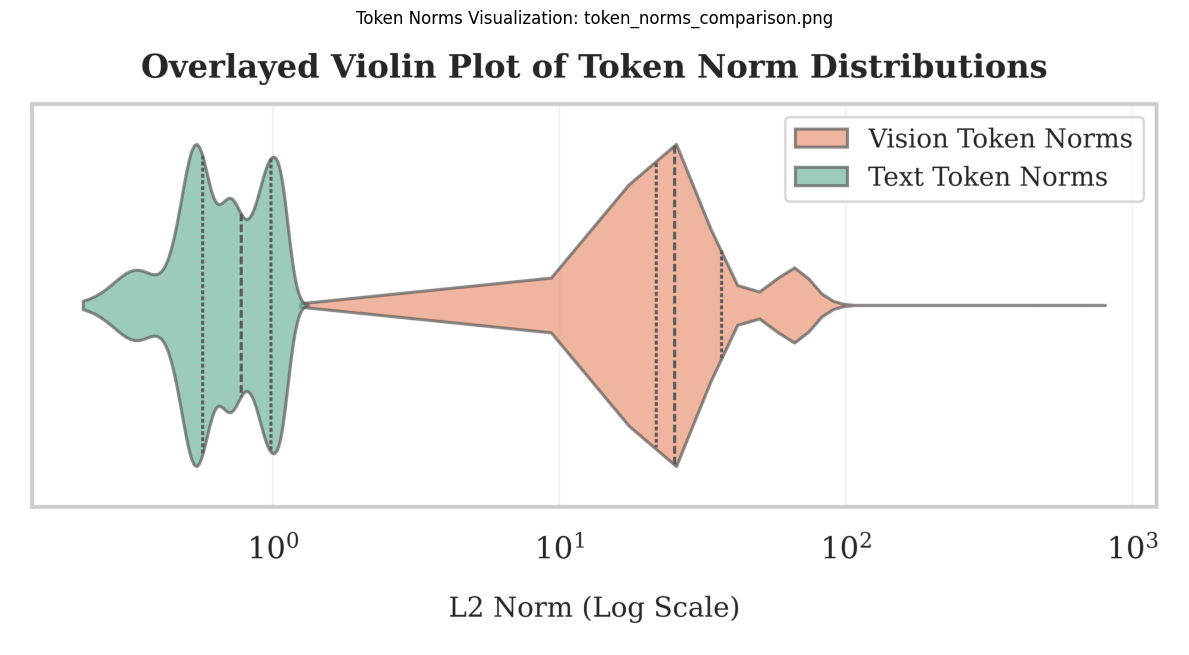

In [13]:
# Visualize the results
import matplotlib.pyplot as plt
from pathlib import Path
import glob

# Find output plots
plot_files = list(Path(out_dir).glob("*.png"))
if plot_files:
    print(f"Found {len(plot_files)} visualization files:")
    for plot_file in plot_files:
        print(f"  - {plot_file.name}")

    # Display the first plot
    img = plt.imread(str(plot_files[0]))
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Token Norms Visualization: {plot_files[0].name}")
    plt.tight_layout()
    plt.show()
else:
    print("No visualization files found. Check the output directory.")


## 6. COCO Diagnostics

Run comprehensive diagnostics over the COCO dataset. This measures:
- **Cross Modality Balance (CMB)**: Vision vs text token attention shares
- **RoPE sensitivity**: Delta_gv (Δ_gv) and delta_alphaV (Δ_alphaV)
- **Hidden norms**: Hidden state norms for system, user, and vision tokens

We'll run this for multiple model variants.


In [14]:
import subprocess
import sys

# Run COCO diagnostics for each model
models_to_test = [
    ("llava-v1.5-7b", model_paths.get("llava-v1.5-7b")),
    # Add other models when available
    ("llava-v1.5-7b-normWmean", model_paths.get("llava-v1.5-7b-normWmean")),
    ("llava-v1.5-7b-multilayerNorm", model_paths.get("llava-v1.5-7b-multilayerNorm")),
]

# Filter out None models
models_to_test = [(name, path) for name, path in models_to_test if path is not None]

print(f"Running diagnostics for {len(models_to_test)} model(s)...")

for model_name, model_path in models_to_test:
    print(f"\n{'='*60}")
    print(f"Processing: {model_name}")
    print(f"{'='*60}")

    # Run with system prompt (sp-0)
    cmd_sp0 = [
        sys.executable, "run_coco_diagnostics.py",
        "--model_path", str(model_path),
        "--image_dir", str(COCO_IMAGE_DIR),
        "--ann_file", str(COCO_ANN_FILE),
        "--out_root", str(RUNS_DIR),
        "--restrict_to_past",
        "--max_new_tokens", "32",
        "--probe_hidden_norms",
        "--hidden_norm_kind", "l2",
        "--max_images", "20"  # Start with 20 for testing
    ]

    print(f"\nRunning with system prompt (sp-0)...")
    result = subprocess.run(cmd_sp0, capture_output=True, text=True)
    if result.returncode == 0:
        print("✓ Completed with system prompt")
    else:
        print(f"✗ Error: {result.stderr}")

    # Run without system prompt (sp-1)
    cmd_sp1 = cmd_sp0 + ["--strip_system_prompt"]

    print(f"\nRunning without system prompt (sp-1)...")
    result = subprocess.run(cmd_sp1, capture_output=True, text=True)
    if result.returncode == 0:
        print("✓ Completed without system prompt")
    else:
        print(f"✗ Error: {result.stderr}")

print("\n✓ COCO diagnostics complete")


Running diagnostics for 3 model(s)...

Processing: llava-v1.5-7b

Running with system prompt (sp-0)...
✓ Completed with system prompt

Running without system prompt (sp-1)...
✓ Completed without system prompt

Processing: llava-v1.5-7b-normWmean

Running with system prompt (sp-0)...
✓ Completed with system prompt

Running without system prompt (sp-1)...
✓ Completed without system prompt

Processing: llava-v1.5-7b-multilayerNorm

Running with system prompt (sp-0)...
✓ Completed with system prompt

Running without system prompt (sp-1)...
✓ Completed without system prompt

✓ COCO diagnostics complete


In [15]:
# Check the output structure
print("Diagnostic results structure:")
for run_dir in RUNS_DIR.iterdir():
    if run_dir.is_dir():
        print(f"\n{run_dir.name}/")
        if (run_dir / "per_image").exists():
            num_images = len(list((run_dir / "per_image").glob("*.json")))
            print(f"  per_image/ ({num_images} images)")
        if (run_dir / "analysis").exists():
            print(f"  analysis/")
            for f in (run_dir / "analysis").glob("*.png"):
                print(f"    - {f.name}")


Diagnostic results structure:

llava-v1.5-7b__sp-0/
  per_image/ (20 images)

llava-v1.5-7b-multilayerNorm__sp-0/
  per_image/ (20 images)

llava-v1.5-7b-normWmean__sp-1/
  per_image/ (20 images)

llava-v1.5-7b-multilayerNorm__sp-1/
  per_image/ (20 images)

llava-v1.5-7b-normWmean__sp-0/
  per_image/ (20 images)

llava-v1.5-7b__sp-1/
  per_image/ (20 images)


## 7. Analyze RoPE Sensitivity Results

Visualize the RoPE (Rotary Position Embedding) sensitivity results, showing delta_gv and delta_alphaV across layers.


In [16]:
# --- RoPE sensitivity analysis (Colab/venv safe) ---
import os
import sys
import subprocess

# Get all run directories
run_dirs = [str(d) for d in RUNS_DIR.iterdir() if d.is_dir() and "__sp-0" in d.name]

if run_dirs:
    print(f"Analyzing {len(run_dirs)} run(s)...")

    # Build command with the current interpreter (not plain "python")
    cmd = [sys.executable, "analyze_coco_diagnostics.py", "--run_dir"] + run_dirs

    # Clone env and remove notebook-specific variables that break matplotlib in a subprocess
    env = os.environ.copy()
    env.pop("MPLBACKEND", None)
    env.pop("JPY_PARENT_PID", None)

    print(f"Command: {' '.join(cmd)}")
    result = subprocess.run(cmd, capture_output=True, text=True, env=env)

    if result.returncode == 0:
        print("\n✓ RoPE sensitivity analysis completed")
        # If the script prints results to stdout, show them
        if result.stdout:
            print(result.stdout)
    else:
        print("\n✗ Error:")
        print(result.stderr or result.stdout or f"Return code: {result.returncode}")
else:
    print("No run directories found. Please run COCO diagnostics first.")


Analyzing 3 run(s)...
Command: /usr/bin/python3.real analyze_coco_diagnostics.py --run_dir /content/spatial-awareness-draft-main/runs/llava-v1.5-7b__sp-0 /content/spatial-awareness-draft-main/runs/llava-v1.5-7b-multilayerNorm__sp-0 /content/spatial-awareness-draft-main/runs/llava-v1.5-7b-normWmean__sp-0

✓ RoPE sensitivity analysis completed
{'images_used': 20, 'L': 32, 'H': 32, 'run_dir': '/content/spatial-awareness-draft-main/runs/llava-v1.5-7b__sp-0', 'model_name': 'llava-v1.5-7b', 'strip_system_prompt': False, 'delta_steps': 1.0, 'mean_avg_abs_delta_gv': 0.007262426808420131, 'mean_avg_delta_alphaV': 0.0008666756230923056}
[OK] analyzed 20 images for /content/spatial-awareness-draft-main/runs/llava-v1.5-7b__sp-0
{'images_used': 20, 'L': 32, 'H': 32, 'run_dir': '/content/spatial-awareness-draft-main/runs/llava-v1.5-7b-multilayerNorm__sp-0', 'model_name': 'llava-v1.5-7b-multilayerNorm', 'strip_system_prompt': False, 'delta_steps': 1.0, 'mean_avg_abs_delta_gv': 0.008215886606035738, '

Found 1 RoPE sensitivity plots:


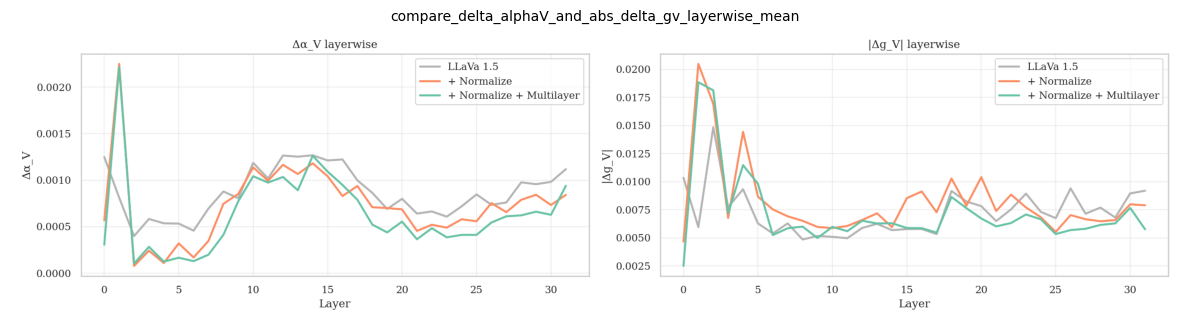

In [34]:
# Display the generated plots
rope_plots = list(RUNS_DIR.glob("compare_delta_alphaV_and_abs_delta_gv_layerwise_mean.png"))
if rope_plots:
    print(f"Found {len(rope_plots)} RoPE sensitivity plots:")

    fig, axes = plt.subplots(1, len(rope_plots), figsize=(12*len(rope_plots), 10))
    if len(rope_plots) == 1:
        axes = [axes]

    for ax, plot_file in zip(axes, rope_plots):
        img = plt.imread(str(plot_file))
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(plot_file.stem, fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print("No RoPE sensitivity plots found.")


## 8. Analyze System Prompt Attention Shares

Visualize how much attention is allocated to the system prompt vs vision vs user text tokens.


In [18]:
# --- System prompt attention analysis (Colab/venv safe) ---
import os
import sys
import subprocess

# Get all run directories
run_dirs = [str(d) for d in RUNS_DIR.iterdir() if d.is_dir() and "__sp-" in d.name]

if run_dirs:
    print(f"Analyzing system prompt attention for {len(run_dirs)} run(s)...")

    # Use current interpreter and pass run directories as args
    cmd = [sys.executable, "system_prompt_plot.py", "--run_dir"] + run_dirs

    # Clone environment and strip Jupyter-specific variables
    env = os.environ.copy()
    env.pop("MPLBACKEND", None)
    env.pop("JPY_PARENT_PID", None)

    print(f"Command: {' '.join(cmd)}")

    # Run analysis
    result = subprocess.run(cmd, capture_output=True, text=True, env=env)

    if result.returncode == 0:
        print("\n✓ System prompt analysis completed")
        if result.stdout:
            print(result.stdout)
    else:
        print("\n✗ Error:")
        print(result.stderr or result.stdout or f"Return code: {result.returncode}")
else:
    print("No run directories found.")


Analyzing system prompt attention for 6 run(s)...
Command: /usr/bin/python3.real system_prompt_plot.py --run_dir /content/spatial-awareness-draft-main/runs/llava-v1.5-7b__sp-0 /content/spatial-awareness-draft-main/runs/llava-v1.5-7b-multilayerNorm__sp-0 /content/spatial-awareness-draft-main/runs/llava-v1.5-7b-normWmean__sp-1 /content/spatial-awareness-draft-main/runs/llava-v1.5-7b-multilayerNorm__sp-1 /content/spatial-awareness-draft-main/runs/llava-v1.5-7b-normWmean__sp-0 /content/spatial-awareness-draft-main/runs/llava-v1.5-7b__sp-1

✓ System prompt analysis completed
[OK] wrote pies to /content/spatial-awareness-draft-main/runs/llava-v1.5-7b__sp-0/analysis
[OK] wrote pies to /content/spatial-awareness-draft-main/runs/llava-v1.5-7b-multilayerNorm__sp-0/analysis
[OK] wrote pies to /content/spatial-awareness-draft-main/runs/llava-v1.5-7b-normWmean__sp-1/analysis
[OK] wrote pies to /content/spatial-awareness-draft-main/runs/llava-v1.5-7b-multilayerNorm__sp-1/analysis
[OK] wrote pies to 

Found 12 system prompt plots:


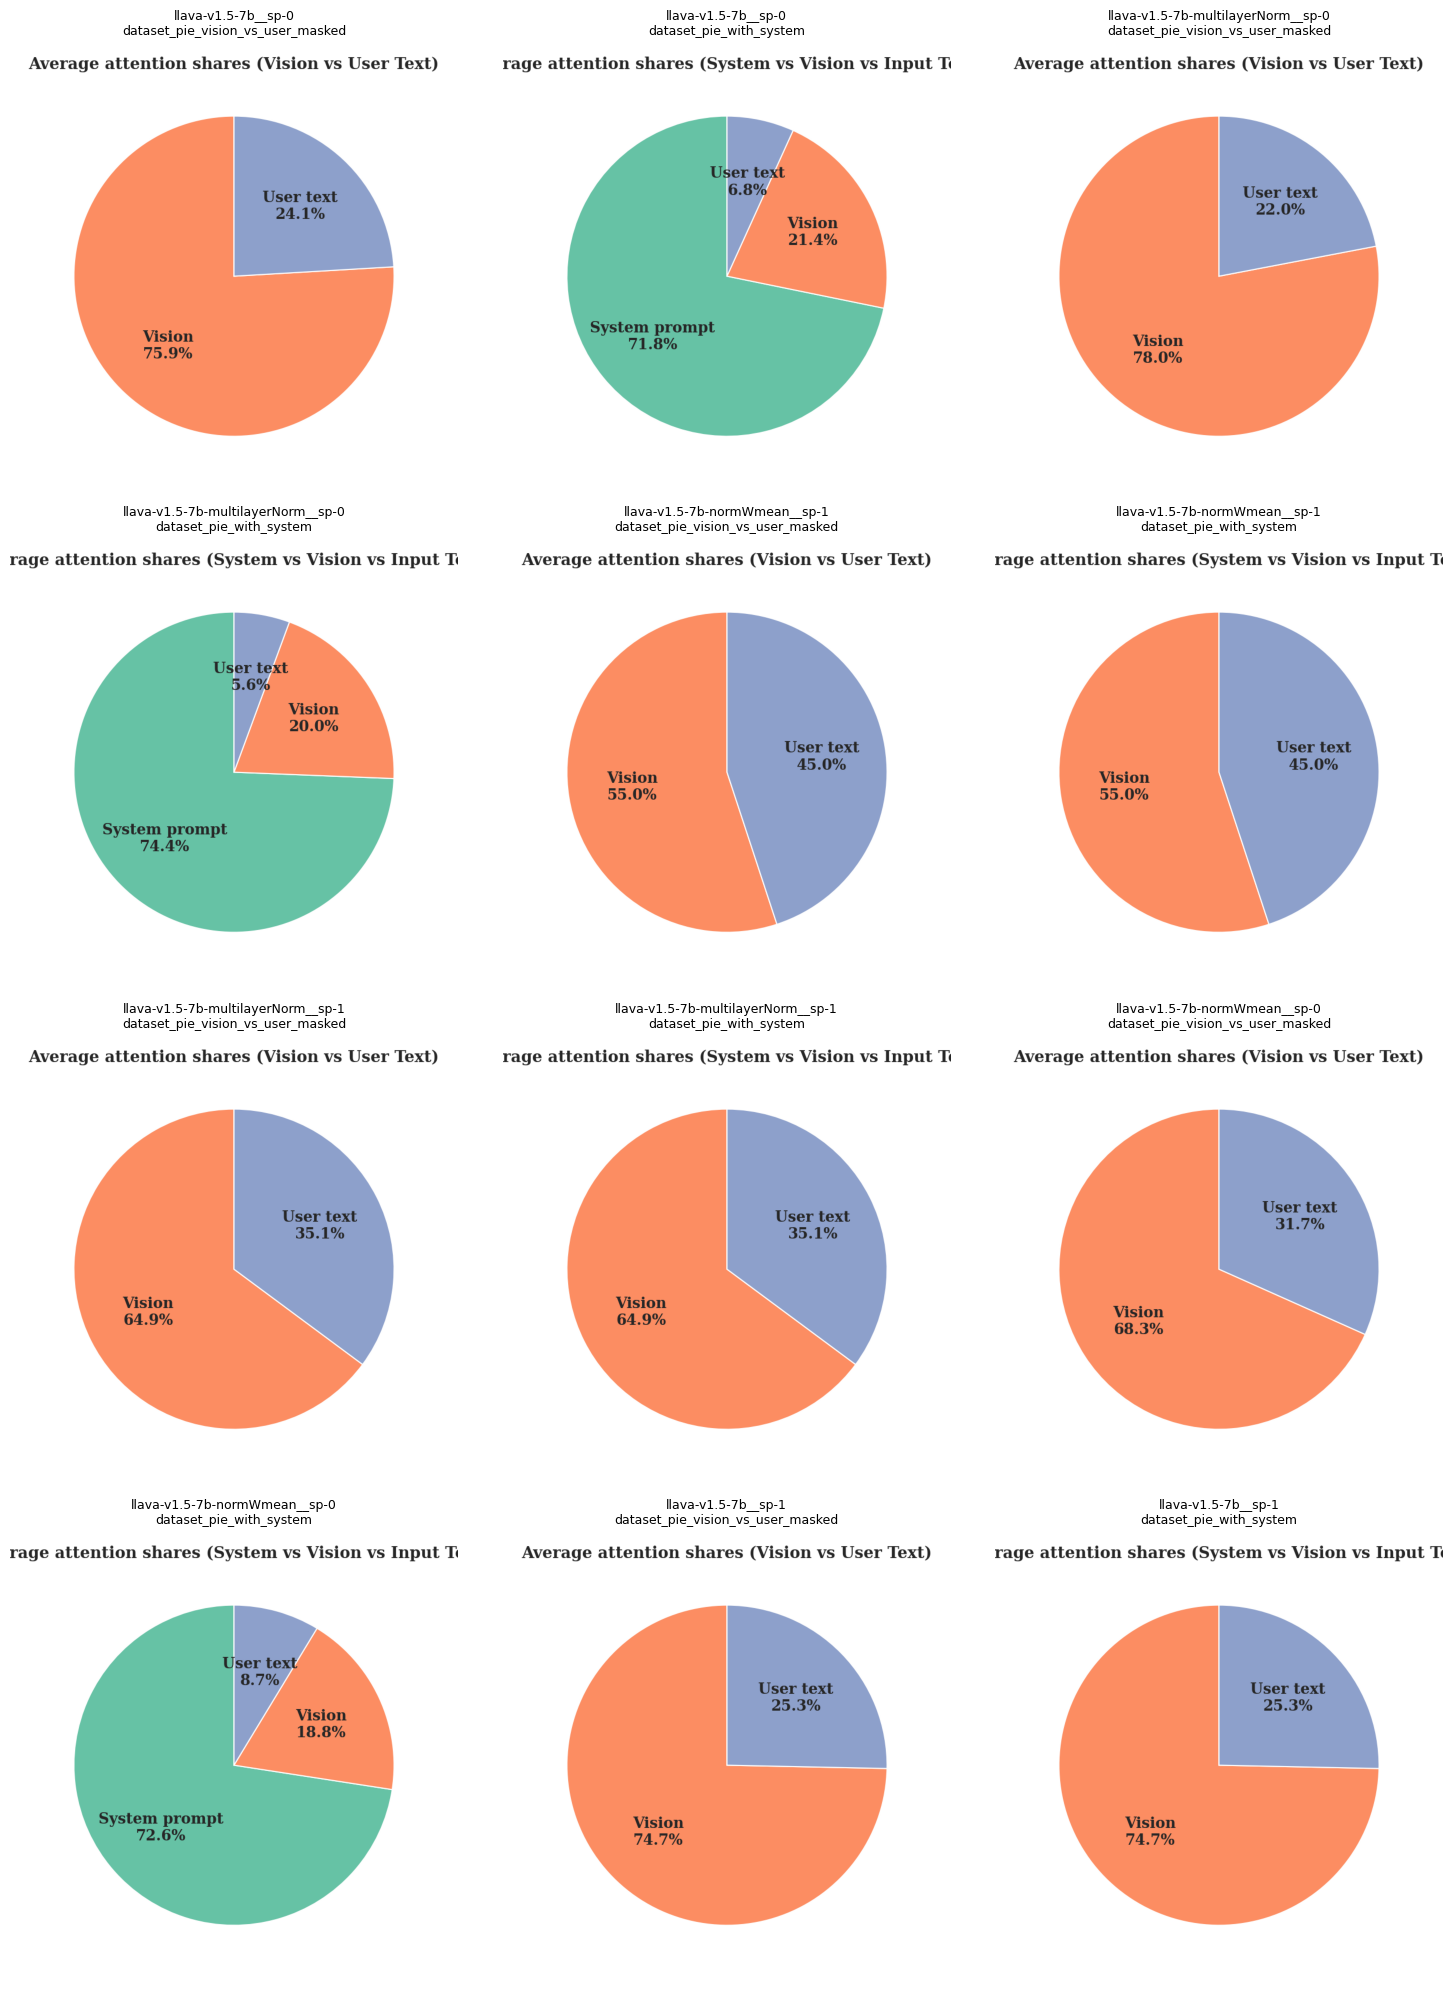

In [19]:
# Display system prompt plots from analysis directories
system_prompt_plots = []
for run_dir in RUNS_DIR.iterdir():
    if run_dir.is_dir() and (run_dir / "analysis").exists():
        plots = list((run_dir / "analysis").glob("*pie*.png"))
        system_prompt_plots.extend(plots)

if system_prompt_plots:
    print(f"Found {len(system_prompt_plots)} system prompt plots:")

    n_plots = len(system_prompt_plots)
    cols = min(3, n_plots)
    rows = (n_plots + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    if n_plots == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if isinstance(axes, list) else [axes]
    else:
        axes = axes.flatten()

    for ax, plot_file in zip(axes[:n_plots], system_prompt_plots):
        img = plt.imread(str(plot_file))
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(plot_file.parent.parent.name + "\n" + plot_file.stem, fontsize=9)

    # Hide extra subplots
    for ax in axes[n_plots:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No system prompt plots found.")


## 9. Visualize Cross Modality Balance (CMB)

Visualize the Cross Modality Balance, showing vision vs text token attention shares. This is a key metric for understanding how the model balances attention between vision and text modalities.


In [20]:
# Visualize average CMB across all images
cmd_avg = [
    "python", "viz_cmb_panel.py",
    "--runs_dir", str(RUNS_DIR),
    "--sp", "0",  # 0 = with system prompt, 1 = without
    "--coco_root", str(COCO_ROOT),
    "--out", "cmb_avg_sp0.png"
]
env = os.environ.copy()
env.pop("MPLBACKEND", None)

print("Generating average CMB visualization (with system prompt)...")
result = subprocess.run(cmd_avg, capture_output=True, text=True, env=env)
if result.returncode == 0:
    print("✓ Average CMB visualization created")
    print(result.stdout)
else:
    print(f"✗ Error: {result.stderr}")


Generating average CMB visualization (with system prompt)...
✓ Average CMB visualization created
Averaging over 20 common .npz files



In [21]:
# Visualize CMB without system prompt
cmd_avg_sp1 = [
    "python", "viz_cmb_panel.py",
    "--runs_dir", str(RUNS_DIR),
    "--sp", "1",  # Without system prompt
    "--coco_root", str(COCO_ROOT),
    "--out", "cmb_avg_sp1.png"
]


print("Generating average CMB visualization (without system prompt)...")
result = subprocess.run(cmd_avg_sp1, capture_output=True, text=True, env=env)
if result.returncode == 0:
    print("✓ Average CMB visualization created")
else:
    print(f"✗ Error: {result.stderr}")


Generating average CMB visualization (without system prompt)...
✓ Average CMB visualization created


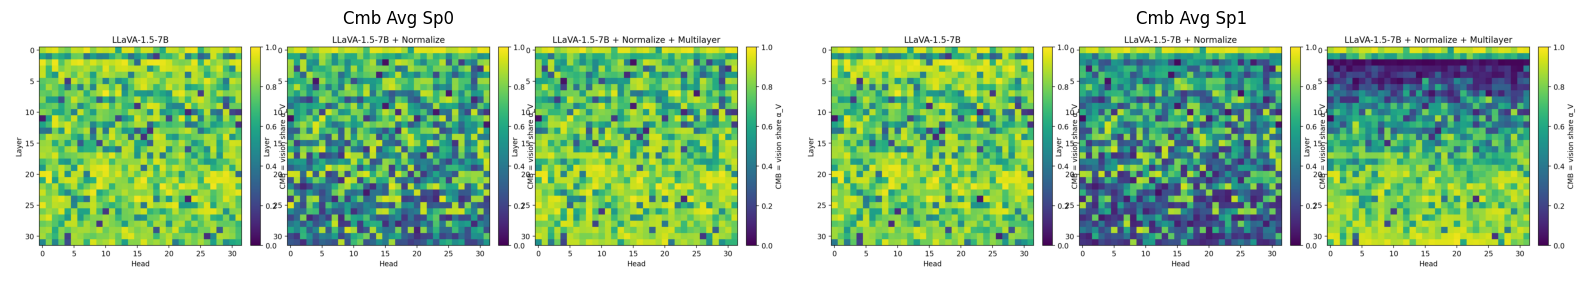

In [22]:
# Display CMB visualizations
cmb_plots = [Path("cmb_avg_sp0.png"), Path("cmb_avg_sp1.png")]
cmb_plots = [p for p in cmb_plots if p.exists()]

if cmb_plots:
    fig, axes = plt.subplots(1, len(cmb_plots), figsize=(8*len(cmb_plots), 6))
    if len(cmb_plots) == 1:
        axes = [axes]

    for ax, plot_file in zip(axes, cmb_plots):
        img = plt.imread(str(plot_file))
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(plot_file.stem.replace('_', ' ').title(), fontsize=12)

    plt.tight_layout()
    plt.show()
else:
    print("CMB plots not found. They should be in the current directory.")


Visualizing CMB for sample image: 000000331352
✓ Single image CMB visualization created


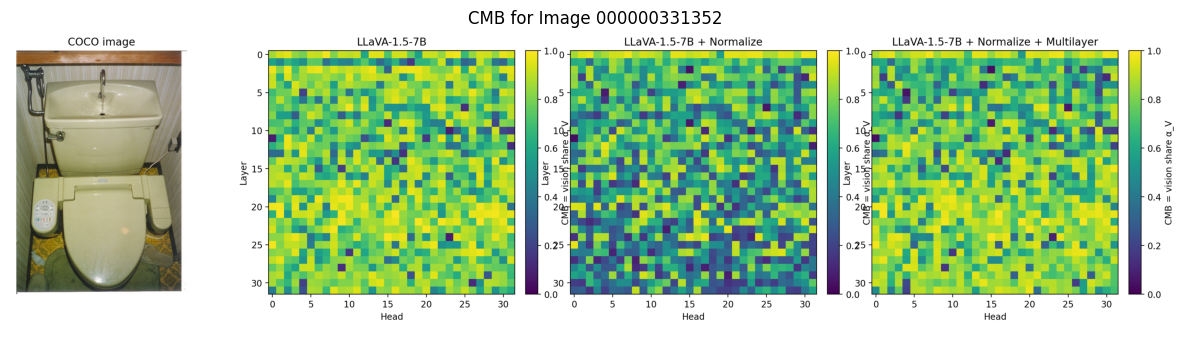

In [23]:
# Visualize CMB for a specific image (example)
# First, get a sample image key from the results
sample_image_key = None
for run_dir in RUNS_DIR.iterdir():
    if run_dir.is_dir() and (run_dir / "per_image").exists():
        json_files = list((run_dir / "per_image").glob("*.json"))
        if json_files:
            sample_image_key = json_files[0].stem
            break

if sample_image_key:
    print(f"Visualizing CMB for sample image: {sample_image_key}")

    cmd_single = [
        "python", "viz_cmb_panel.py",
        "--runs_dir", str(RUNS_DIR),
        "--sp", "0",
        "--image_key", sample_image_key,
        "--coco_root", str(COCO_ROOT),
        "--out", f"cmb_panel_sp0_{sample_image_key}.png"
    ]

    result = subprocess.run(cmd_single, capture_output=True, text=True, env=env)
    if result.returncode == 0:
        print("✓ Single image CMB visualization created")

        # Display it
        plot_path = Path(f"cmb_panel_sp0_{sample_image_key}.png")
        if plot_path.exists():
            img = plt.imread(str(plot_path))
            plt.figure(figsize=(12, 8))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"CMB for Image {sample_image_key}")
            plt.tight_layout()
            plt.show()
    else:
        print(f"✗ Error: {result.stderr}")
else:
    print("No sample image found in results.")


## 10. Visualize Hidden Norms

Analyze and visualize the hidden norms of vision tokens and text tokens across layers. This reveals the scale differences between modalities.


In [24]:
# Visualize average hidden norms (with system prompt)
cmd_hidden = [
    "python", "viz_hidden_norms.py",
    "--runs_dir", str(RUNS_DIR),
    "--sp", "0",
    "--mode", "avg",
    "--logy",
    "--early_k", "6",
    "--out", "hidden_norms_avg_sp0.png"
]

print("Generating hidden norms visualization (with system prompt)...")
result = subprocess.run(cmd_hidden, capture_output=True, text=True, env=env)
if result.returncode == 0:
    print("✓ Hidden norms visualization created")
    print(result.stdout)
else:
    print(f"✗ Error: {result.stderr}")


Generating hidden norms visualization (with system prompt)...
✗ Error: Traceback (most recent call last):
  File "/content/spatial-awareness-draft-main/diagnostic_tools/viz_hidden_norms.py", line 54, in <module>
    import seaborn as sns
ModuleNotFoundError: No module named 'seaborn'



In [25]:
# Visualize hidden norms without system prompt
cmd_hidden_sp1 = [
    "python", "viz_hidden_norms.py",
    "--runs_dir", str(RUNS_DIR),
    "--sp", "1",
    "--mode", "avg",
    "--logy",
    "--early_k", "6",
    "--out", "hidden_norms_avg_sp1.png"
]

print("Generating hidden norms visualization (without system prompt)...")
result = subprocess.run(cmd_hidden_sp1, capture_output=True, text=True, env=env)
if result.returncode == 0:
    print("✓ Hidden norms visualization created")
else:
    print(f"✗ Error: {result.stderr}")


Generating hidden norms visualization (without system prompt)...
✗ Error: Traceback (most recent call last):
  File "/content/spatial-awareness-draft-main/diagnostic_tools/viz_hidden_norms.py", line 54, in <module>
    import seaborn as sns
ModuleNotFoundError: No module named 'seaborn'



In [26]:
# Display hidden norms visualizations
hidden_norm_plots = [Path("hidden_norms_avg_sp0.png"), Path("hidden_norms_avg_sp1.png")]
hidden_norm_plots = [p for p in hidden_norm_plots if p.exists()]

if hidden_norm_plots:
    fig, axes = plt.subplots(1, len(hidden_norm_plots), figsize=(8*len(hidden_norm_plots), 5))
    if len(hidden_norm_plots) == 1:
        axes = [axes]

    for ax, plot_file in zip(axes, hidden_norm_plots):
        img = plt.imread(str(plot_file))
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(plot_file.stem.replace('_', ' ').title(), fontsize=12)

    plt.tight_layout()
    plt.show()
else:
    print("Hidden norms plots not found.")


Hidden norms plots not found.


## 11. Visualize Attention Heatmaps Over Images

Visualize attention heatmaps showing which image regions the model attends to when generating specific tokens. This is useful for understanding spatial awareness.


We are using "COCO/val2017/000000445658.jpg" here. Our question is "Where is the teddy bear", and we want to know where are the attention focusing on the image for the target word "teddy". We can see the teddy bear is on top of the oven in the image. For 3 models, we see the normalized version has the most attention focused on the right object.

In [27]:
# Visualize average Attention overlay
cmd_attention_overlay = [
    sys.executable, "viz_attention_image.py"
]

print("Generating attention overlay visualization ...")
result = subprocess.run(cmd_attention_overlay, capture_output=True, text=True, env=env)
if result.returncode == 0:
    print("✓ Attention overlay visualization created")
    print(result.stdout)
else:
    print(f"✗ Error: {result.stderr}")


Generating attention overlay visualization ...
✓ Attention overlay visualization created
spatial coordinates: False
Generated Text: <s> The teddy bear is sitting on the stove in the kitchen.</s>
Target word token: 29748 (ted)
Token position: 2
Token at position: ted
Adjacent tokens: The teddy bear is
spatial coordinates: False
Generated Text: <s> The teddy bear is sitting on the stove in the kitchen.</s>
Target word token: 29748 (ted)
Token position: 2
Token at position: ted
Adjacent tokens: The teddy bear is
spatial coordinates: False
Using multilayer features. Input size adjusted to: 4096
Generated Text: <s> The teddy bear is sitting on the kitchen counter.</s>
Target word token: 29748 (ted)
Token position: 2
Token at position: ted
Adjacent tokens: The teddy bear is
Saved comparison plot to: attention_comparison.png
Saved overlay to: attention_overlay_llava-v1.5-7b.png
Saved overlay to: attention_overlay_llava-v1.5-7b-normWmean.png
Saved overlay to: attention_overlay_llava-v1.5-7b-mu

Displaying attention_comparison.png


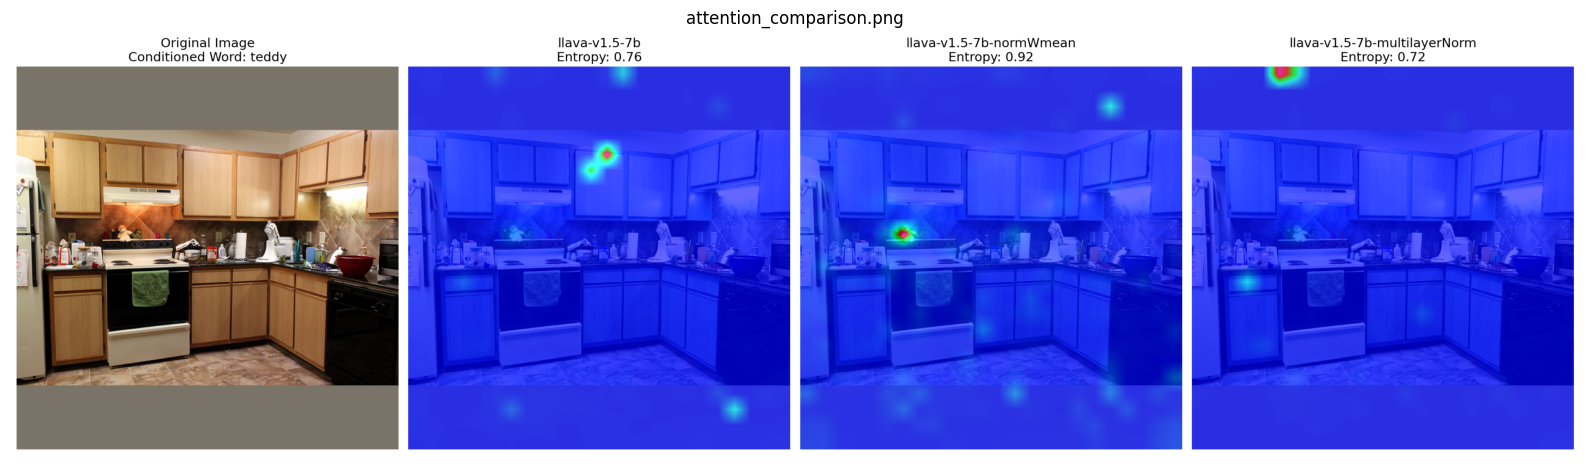

In [28]:
import matplotlib.pyplot as plt
from pathlib import Path

# Display the generated comparison plot
comparison_plot_path = Path("attention_comparison.png")
if comparison_plot_path.exists():
    print(f"Displaying {comparison_plot_path.name}")
    img = plt.imread(str(comparison_plot_path))
    plt.figure(figsize=(16, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(comparison_plot_path.name)
    plt.tight_layout()
    plt.show()
else:
    print(f"{comparison_plot_path.name} not found.")


## 12. Summary and Next Steps

Congratulations! You've completed the diagnostic tools walkthrough. Here's a summary of what we've covered:

### Completed Analyses:

1. ✅ **Token Norms Analysis** - Analyzed L2-norm distributions for vision and text tokens
2. ✅ **COCO Diagnostics** - Ran comprehensive diagnostics measuring CMB, RoPE sensitivity, and hidden norms
3. ✅ **RoPE Sensitivity Analysis** - Visualized positional encoding sensitivity (delta_gv, delta_alphaV)
4. ✅ **System Prompt Analysis** - Analyzed attention allocation to system prompts
5. ✅ **Cross Modality Balance (CMB)** - Visualized vision vs text token attention shares
6. ✅ **Hidden Norms Visualization** - Compared hidden norms across layers
7. ✅ **Attention Heatmaps** - Visualized spatial attention patterns over images

### Key Insights:

- **CMB (Cross Modality Balance)**: Shows how the model balances attention between vision and text tokens
- **RoPE Sensitivity**: Reveals how sensitive the model is to positional encoding changes
- **Hidden Norms**: Highlights scale differences between vision and text token representations
- **Attention Patterns**: Shows which image regions the model focuses on when generating specific words

### Next Steps:

1. **Increase dataset size**: Change `--max_images` from 20 to a larger number (or remove it to analyze the full COCO dataset)
2. **Compare model variants**: Add more model variants to compare their diagnostic results
3. **Custom analysis**: Use the extracted data in the `runs/` directory for custom analyses
4. **Experiment with parameters**: Try different values for `--max_new_tokens`, `--strip_system_prompt`, etc.

### Output Locations:

- **Token norms**: `outputs/token_norms/`
- **Diagnostic results**: `runs/`
- **Visualizations**: Current directory (`.png` files)
- **Analysis plots**: `runs/*/analysis/`
